In [1]:
%load_ext autoreload
%autoreload 2
import os
import cv2
from vehicle_reid.embedder import Embedder
from vehicle_reid.evaluate import Evaluator
from vehicle_reid import exp_config
from vehicle_reid.common import *
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import h5py
EXP_ROOT = "/home/hthieu/AICityChallenge2019/track2_experiments/"
EXP_ID = "180419_triplet-reid_pre-trained_densenet161_track2_small_512/"
# EXP_ID = "270419_triplet-reid_pre-trained_densenet161_track2_small"
TRAIN_ROOT = "/home/hthieu/AICityChallenge2019/data/Track2Data/image_train/"
TEST_ROOT  = "/home/hthieu/AICityChallenge2019/data/Track2Data/image_test/"
GPU_ID = "1"
EXP_DIR = os.path.join(EXP_ROOT,EXP_ID)
VIEW_QUE = os.path.join(EXP_DIR, "que_views.h5")

In [3]:
TEST_BEST_IMG = {
    'root': TEST_ROOT,
    'csv_in': "data/track2_test_best_imgs.csv",
    "out_h5": "query_ext/test_best_imgs.h5"
}
TEST_FULL = {
    'root': TEST_ROOT,
    'csv_in': "data/track2_test_v3.csv",
    "out_h5": "query_ext/test_full_imgs.h5"
}
TRAIN_FULL = {
    'root': "/home/hthieu/AICityChallenge2019/data/",
    'csv_in': "data/track2_train_v3.csv",
    "out_h5": "query_ext/train_full_imgs.h5"
}
TEST_3IMGS = {
    'root': TEST_ROOT,
    'csv_in': "data/track2_test_avt_3_imgs.csv",
    "out_h5": "query_ext/test_avt_3_imgs.h5"
}
TRAIN_3IMGS = {
    'root': TRAIN_ROOT,
    'csv_in': "data/track2_train_avt_3_imgs.csv",
    "out_h5": "query_ext/test_train_3_imgs.h5"
}

In [4]:
#EMBED FRONT
cfg = TEST_BEST_IMG
embedder = Embedder(exp_config.FrontEmbedder.EXP_ID,GPU_ID)
embedder.embed_csv_file(cfg['root'], cfg['csv_in'],"query_ext/emb_front_best_imgs.h5")

Loading args from /home/hthieu/AICityChallenge2019/track2_experiments/260419_triplet-reid_pre-trained_densenet161_track2_full_front/args.json.
False False
INFO:tensorflow:Scale of 0 disables regularizer.


KeyboardInterrupt: 

In [ ]:
#EMBED REAR
cfg = TEST_BEST_IMG
embedder = Embedder(exp_config.RearEmbedder.EXP_ID,GPU_ID)
embedder.embed_csv_file(cfg['root'], cfg['csv_in'],"query_ext/emb_rear_best_imgs.h5")

In [ ]:
#EMBED SIDE
cfg = TEST_BEST_IMG
embedder = Embedder(exp_config.SideEmbedder.EXP_ID,GPU_ID)
embedder.embed_csv_file(cfg['root'], cfg['csv_in'],"query_ext/emb_side_best_imgs.h5")

In [ ]:
# NORMAL EMBED
cfg = TEST_BEST_IMG
embedder = Embedder(EXP_DIR, GPU_ID)
embedder.embed_csv_file(cfg['root'], cfg['csv_in'],cfg["out_h5"], flip = True, crop = 'five')

In [3]:
# NORMAL EMBED
cfg = TEST_3IMGS
embedder = Embedder(EXP_DIR, GPU_ID)
embedder.embed_csv_file(cfg['root'], cfg['csv_in'],cfg["out_h5"])

Loading args from /home/hthieu/AICityChallenge2019/track2_experiments/180419_triplet-reid_pre-trained_densenet161_track2_small_512/args.json.
False False
INFO:tensorflow:Scale of 0 disables regularizer.
Save h5 file to:  query_ext/test_avt_3_imgs.h5
Restoring from checkpoint: /home/hthieu/AICityChallenge2019/track2_experiments/180419_triplet-reid_pre-trained_densenet161_track2_small_512/checkpoint-30000
INFO:tensorflow:Restoring parameters from /home/hthieu/AICityChallenge2019/track2_experiments/180419_triplet-reid_pre-trained_densenet161_track2_small_512/checkpoint-30000
Embedded batch 2304-2394/2394
Done with embedding, aggregating augmentations...
(2394, 512)
(2394, 512)


In [ ]:
# LOAD EMB RESULTS IN MULTIPLE VIEWS
emb_front = load_h5("query_ext/emb_front_best_imgs.h5", "emb")
emb_rear  = load_h5("query_ext/emb_rear_best_imgs.h5", "emb")
emb_side  = load_h5("query_ext/emb_side_best_imgs.h5", "emb")
img_id = load_h5("query_ext/emb_front_best_imgs.h5", "id")
img_fol = load_h5("query_ext/emb_front_best_imgs.h5", "fol_id")
evaluator = Evaluator(EXP_DIR, GPU_ID)
dist_front = evaluator.calculate_distances(emb_front,emb_front)
dist_rear = evaluator.calculate_distances(emb_rear,emb_rear)
dist_side = evaluator.calculate_distances(emb_side,emb_side)

In [6]:
# cfg = TEST_BEST_IMG
# cfg = TRAIN_3IMGS
cfg = TEST_3IMGS
f = h5py.File(cfg["out_h5"], 'r')
train_best_emb = np.array(f['emb'])
train_best_id  = np.array(f['id'])
train_best_fol = np.array(f['fol_id'])
# train_aug_emb  = np.array(f['emb_aug'])

In [7]:
x = train_best_emb
tracklet_emb = np.average(x.reshape(x.shape[0]//3,-1,x.shape[1]), axis = 1)
evaluator = Evaluator(EXP_DIR, GPU_ID)
dist = evaluator.calculate_distances(tracklet_emb,tracklet_emb)
save_dist(dist, "test_3_avt_imgs")


(798, 798)


In [10]:
_, img_paths, __ = read_csv_dataset("data/track2_train_best_imgs.csv")
img_paths = [os.path.join(TRAIN_ROOT,x) for x in img_paths]
img_paths = np.array(img_paths)
dist = load_h5("results_dists/train_3_avt_imgs.h5")
view_cls = load_txt_float32("results_classifier/bnminh_train_track_avt_img_list_2704_scores.txt")
x = view_cls
view_cls = np.average(x.reshape(x.shape[0]//3,-1,x.shape[1]), axis = 1)
view_dist = np.sum(view_cls[None,:] * view_cls[:, None], axis = 2)

In [8]:
_, img_paths, __ = read_csv_dataset("data/track2_test_best_imgs.csv")
img_paths = [os.path.join(TEST_ROOT,x) for x in img_paths]
img_paths = np.array(img_paths)
dist = load_h5("results_dists/test_3_avt_imgs.h5")
# view_cls = load_txt_float32("results_classifier/bnminh_test_track_avt_img_list_2704_scores.txt")
# x = view_cls
# view_cls = np.average(x.reshape(x.shape[0]//3,-1,x.shape[1]), axis = 1)
# view_dist = np.sum(view_cls[None,:] * view_cls[:, None], axis = 2)

In [39]:
img_paths[0]

'/home/hthieu/AICityChallenge2019/data/Track2Data/image_test/000029.jpg'

[797 386 306  87  69 741 582 287 469 529 350 120 106 421 143 665 518 101
  99 468  72 763 567 649 107 272 631 319 570 618]


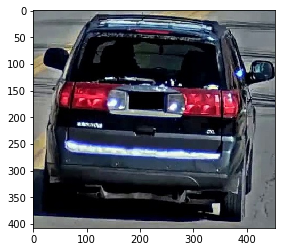

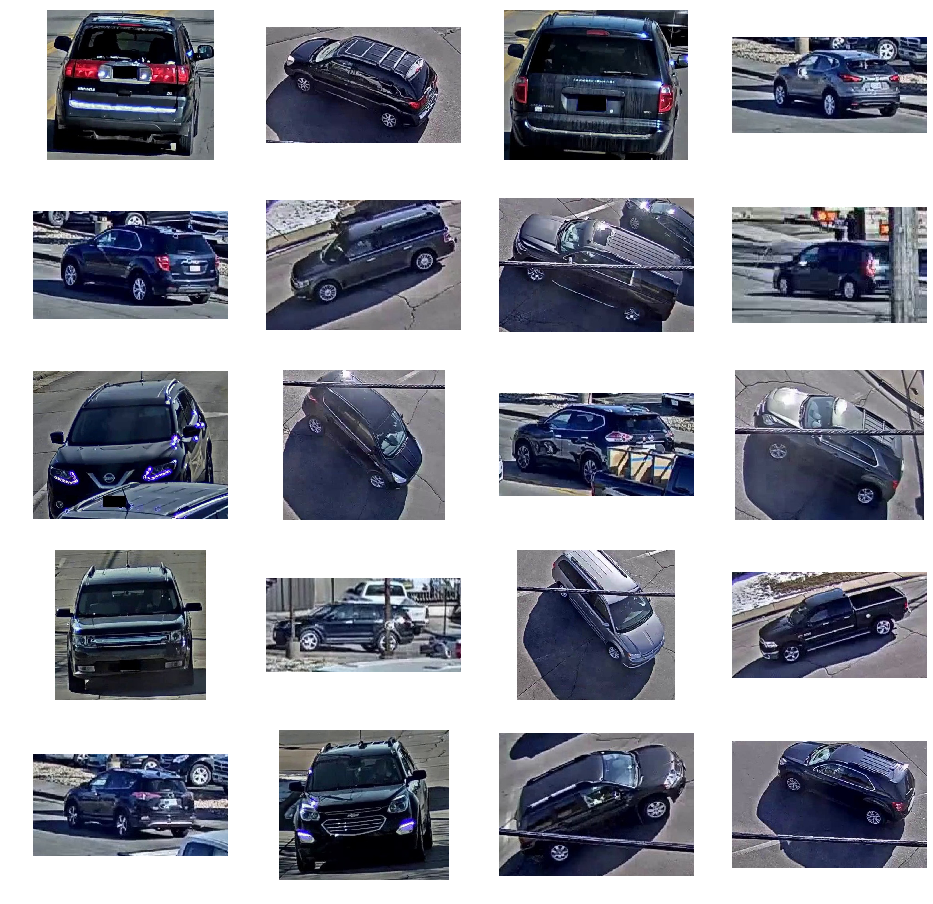

In [9]:
TRACK = 797
vis_img(img_paths[TRACK])
top20 = img_paths[np.argsort(dist[TRACK,:])[:30]]
print(np.argsort(dist[TRACK,:])[:30])
# print(view_dist[np.argsort(dist[TRACK,:])[:30]])
# print(view_cls[TRACK])
vis_img_group(top20,4,5)

In [ ]:
uni_ids = np.unique(train_best_id)
positive_mask, negative_mask = get_masks(train_best_id)

In [16]:
#CALCULATE DISTANCE MATRIX
evaluator = Evaluator(EXP_DIR, GPU_ID)
dist = evaluator.calculate_distances(train_best_emb,train_best_emb)
save_dist(dist, "test_3_avt_imgs")


(2394, 2394)


In [107]:
#LOAD DISTANCE MATRIX
dist = load_h5("results_dists/test_3_avt_imgs.h5")
dist.shape

(798, 798)

In [32]:
#LOAD VIEW SCORES
view_cls = load_txt_float32("results_classifier/bnminh_train_track_avt_img_list_2704_scores.txt")
view_sim = view_cls[:,None] * view_cls[None,:]

In [ ]:
# SAVE VIEW SIMILARITY MATRIX
view_sim = np.sum(view_sim, axis=2)
save_txt(view_sim, "view_simi.txt")

In [ ]:
all_dist = np.concatenate([dist_front[...,None], dist_rear[...,None], dist_side[...,None]], axis=2)
view_filter = np.where(view_sim > 0.5, all_dist, 10000)
dist_views = (all_dist * (1 - view_filter)) * (view_sim > 0.5)

In [ ]:
print(view_cls[5])

In [ ]:
VIEW = 18
print(view_cls[VIEW])
print(top20)
top20 = np.argsort(view_filter[VIEW,:,np.argmax(view_cls[VIEW])])[:20]
vis_img(os.path.join(TEST_ROOT,img_paths[VIEW]))
vis_img_group(img_paths[top20],4,5)


In [61]:
#SELECT TRACK AVATAR (2 IMAGES - 3 IMAGES PER TRACK)
avt_imgs = []
with open("../data/Track2Data/test_track.txt") as fi:
    for i, info in enumerate(fi):
        info = info.strip().split(' ')
        avts = [info[0]]
        if (len(info)<2):
            avts.append(info[0])
        else:
            avts.append(info[len(info)//2])
        avts.append(info[-1])
        for avt in avts:
            avt_imgs.append((i, avt))

print(len(avt_imgs))
with open("test_track_avt_img_list.txt", "w") as fo:
    for img in avt_imgs:
        fo.write("{},{}\n".format(img[1],img[0]))
with open("data/track2_test_avt_3_imgs.csv", "w") as fo:
    for img in avt_imgs:
        fo.write("1,{},{}\n".format(img[1],img[0]))

2394


In [ ]:
train_avt_view_cls = load_txt_float32("results_classifier/bnminh_train_track_avt_img_list_scores.txt")
train_view = []
for i in range(0,len(train_avt_view_cls),2):
    train_view.append(np.max(train_avt_view_cls[i:i+1], axis = 0))
train_view = np.array(train_view)
train_view = train_view > 0.5

front = np.argwhere(train_view[:,0])
rear = np.argwhere(train_view[:,1])
side = np.argwhere(train_view[:,2])

all_id, all_paths, all_trlet = read_csv_dataset("data/track2_train_v3.csv")
def split_by_view(selected_trlet, out_file):
    with open(out_file,"w") as fo:
        for i in range(len(all_paths)):
            if int(all_trlet[i]) in selected_trlet:
                fo.write("{},{},{}\n".format(all_id[i],all_paths[i],all_trlet[i]))
    fo.close()
    
split_by_view(front, "data/track2_train_front.csv")
split_by_view(rear, "data/track2_train_rear.csv")
split_by_view(side, "data/track2_train_side.csv")
# a = np.sum(train_view > 0.4,axis = 1)
# unique, counts = np.unique(a, return_counts=True)
# print(dict(zip(unique, counts)))
# print(np.sum(train_view > 0.4,axis = 0))
# train_avt_view_cls.shape
# print(train_view[9]>0.5)
# print(train_view[9])
# print(train_avt_view_cls[18], avt_imgs[18])
# print(train_avt_view_cls[19], avt_imgs[19])

In [ ]:
img_paths = [os.path.join(TEST_ROOT, x) for x in img_paths]
img_paths = np.array(img_paths, dtype=np.str)
x = view_cls[:,0]
x = np.argwhere(x > 0.5)
vis_img_group(img_paths[x[:,0]])
# print(img_paths.shape)
# imgs_paths[x]
# vis_img_group(img_paths)
# print(type(img_paths))

In [12]:
# VALIDATE PROCESS
ids, paths, tracks = read_csv_dataset("data/track2_validate_v3.csv")
tracks = np.array(tracks).astype(np.int32)
np.unique(tracks).shape
# print(np.unique(tracks.astype(np.int32)))

(529,)

In [ ]:
positive_val = positive_mask.astype(np.float32) * dist
negative_val = negative_mask.astype(np.float32) * dist
print(positive_val.shape)
print('Max pos: ', np.max(dist[positive_mask]))
print('Min pos: ', np.min(dist[positive_mask]))
print('Mean pos: ', np.mean(dist[positive_mask]))
print('STD pos : ', np.std(dist[positive_mask]))
print('------')
print('Max neg: ', np.max(dist[negative_mask]))
print('Min neg: ', np.min(dist[negative_mask]))
print('Mean neg: ', np.mean(dist[negative_mask]))
print('STD neg : ', np.std(dist[negative_mask]))
print(dist[positive_mask].shape)
print(dist[negative_mask].shape)

In [ ]:
x = np.where(positive_val == 0, np.max(positive_val), positive_val)
top20 = np.sort(x, axis=None)[:20]
imgs = []
for i in top20:
    tmp = np.where(x == np.min(i))
    imgs.append(int(tmp[0]))
    imgs.append(int(tmp[1]))

In [ ]:
f =  h5py.File("query_ext/test_distances.h5", "w")
f.create_dataset("distances", data=dist)
f.close()

In [ ]:
f =  h5py.File("query_ext/test_distances.h5", "r")
f.close()

In [ ]:
imgs = []
tri = np.tril(np.ones(same_id.shape, dtype=np.bool))
x = np.where(tri, dist, 0)
fil = np.logical_and((x<13),(x>12.5))
top20 = np.sort(dist[fil], axis=None)[-20:]
for i in top20:
    tmp = np.where(x == i)
    imgs.append((int(tmp[0]), int(tmp[1])))

In [ ]:
imgs = []
with open("vis_dtle.txt") as fi:
    for info in fi:
        info = info.strip().split(" ")
        imgs.append((int(info[0]), int(info[1])))

In [ ]:
id2img = {}
import csv
with open("data/track2_test_best_imgs.csv") as fo:
    csv_reader = csv.reader(fo, delimiter = ',')
    for info in csv_reader:
        id2img[int(info[2])] = os.path.join(TEST_ROOT,info[1])
        
for img in imgs:
    print(img, dist[img[0], img[1]])
    fig=plt.figure(figsize=(10, 10))
    fig.add_subplot(1, 2, 1)
    im = plt.imread(id2img[img[0]])
    plt.axis("off")
    plt.imshow(im)
    fig.add_subplot(1, 2, 2)
    im2 = plt.imread(id2img[img[1]])
    plt.axis("off")
    plt.imshow(im2)
    plt.show()
    plt.figure()

In [ ]:
w=20
h=20
fig=plt.figure(figsize=(10, 10))
columns = 2
rows = 1
print(imgs)
for i in range(0, columns*rows +1):
    print(dist[imgs[i-1], imgs[i]])
    fig.add_subplot(rows, columns, i % 2 + 1)
    im = plt.imread(id2img[imgs[i-1]])
    plt.axis("off")
    plt.imshow(im)
plt.show()

In [ ]:
with open("test_dist.txt", "w") as fo:
    for x in dist:
        for y in x:
            fo.write("{:.5f} ".format(y))
        fo.write("\n")
    fo.close()

In [ ]:
def apply_thresh(thres):
    tri = np.tril(np.ones(dist.shape, dtype=np.bool))
    positive_filter = np.where(dist<thres, True, False)
#     print("Total connection: ", np.sum(positive_filter))
    incorrect = np.logical_xor(positive_filter, same_id)
    incorrect = np.logical_and(incorrect,tri)
    return np.sum(incorrect)
print(apply_thresh(12))